In [1]:
from pathlib import Path

import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dm_control.rl.control import PhysicsError
from tqdm import tqdm, trange

from flygym import Camera, Fly, SingleFlySimulation
from flygym.arena import GappedTerrain
from flygym.examples import PreprogrammedSteps
from flygym.examples.cpg_controller import CPGNetwork
from flygym.preprogrammed import get_cpg_biases
from viz import merge_frame_and_time_series

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
########### SCRIPT PARAMS ############
ENVIRONEMENT_SEED = 0

########### SIM PARAMS ############
Z_SPAWN_POS = 0.5
timestep = 1e-4
stabilization_time1 = 0.04
stabilization_time2 = 0
run_time = 1

########### CPG PARAMS ############
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = get_cpg_biases("tripod")
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

########### HYBRID PARAMS ############
correction_vectors = {
    # unit: radian
    "F": np.array([-0.03, 0, 0, -0.03, 0, 0.03, 0.03]),
    "M": np.array([-0.015, 0.001, 0.025, -0.02, 0, -0.02, 0.0]),
    "H": np.array([0, 0, 0, -0.02, 0, 0.01, -0.02]),
}

right_leg_inversion = [1, -1, -1, 1, -1, 1, 1]
stumbling_force_threshold = -1
correction_rates = {"retraction": (800, 700), "stumbling": (2200, 2100)}
max_increment = 80
retraction_persistance = 20
persistance_init_thr = 20

In [4]:
np.random.seed(ENVIRONEMENT_SEED)
n_exp = 20
max_x = 4.0
shift_x = 2.0
max_y = 4.0
shift_y = 2.0

positions = np.zeros((n_exp, 3))
positions[:, :2] = np.random.rand(n_exp, 2) * (max_x, max_y) - (shift_x, shift_y)
positions[:, 2] = Z_SPAWN_POS
internal_seeds = np.arange(n_exp)

pos = positions[-1]
seed = internal_seeds[-1]

preprogrammed_steps = PreprogrammedSteps()

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in preprogrammed_steps.legs
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# Initialize the simulation
fly = Fly(
    enable_adhesion=True,
    draw_adhesion=True,
    init_pose="stretch",
    control="position",
    spawn_pos=pos,
    contact_sensor_placements=contact_sensor_placements,
)
cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right_top_zoomout",
    play_speed=0.1,
    window_size=(700, 560),
)

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=GappedTerrain(),
)

cpg_network = CPGNetwork(
    timestep=timestep,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=seed,
)

In [5]:
n_stabilization_steps1 = int(stabilization_time1 / sim.timestep)
n_stabilization_steps2 = int(stabilization_time2 / sim.timestep)
n_stabilization_steps = n_stabilization_steps1 + n_stabilization_steps2
n_steps_base = int(run_time / sim.timestep)
n_steps_total = n_stabilization_steps + n_steps_base

retraction_correction = np.zeros(6)
stumbling_correction = np.zeros(6)

detected_segments = ["Tibia", "Tarsus1", "Tarsus2"]
stumbling_sensors = {leg: [] for leg in preprogrammed_steps.legs}
for j, sensor_name in enumerate(sim.fly.contact_sensor_placements):
    leg = sensor_name.split("/")[1][:2]  # sensor_name: eg. "Animat/LFTarsus1"
    segment = sensor_name.split("/")[1][2:]
    if segment in detected_segments:
        stumbling_sensors[leg].append(j)
stumbling_sensors = {k: np.array(v) for k, v in stumbling_sensors.items()}

obs, info = sim.reset()

t_frames = []
obs_list = []
retraction_perisitance_counter = np.zeros(6)
physics_error = False

for i in trange(n_steps_total):
    # retraction rule: does a leg need to be retracted from a hole?
    end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
    end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
    end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
    if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.06:
        leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
        if retraction_correction[leg_to_correct_retraction] > persistance_init_thr:
            retraction_perisitance_counter[leg_to_correct_retraction] = 1
    else:
        leg_to_correct_retraction = None

    # update persistance counter
    retraction_perisitance_counter[retraction_perisitance_counter > 0] += 1
    retraction_perisitance_counter[
        retraction_perisitance_counter > retraction_persistance
    ] = 0

    cpg_network.step()
    joints_angles = []
    adhesion_onoff = []

    for j, leg in enumerate(preprogrammed_steps.legs):
        # update amount of retraction correction
        if (
            j == leg_to_correct_retraction or retraction_perisitance_counter[j] > 0
        ):  # lift leg
            increment = correction_rates["retraction"][0] * sim.timestep
            retraction_correction[j] += increment
            sim.fly.change_segment_color(sim.physics, f"{leg}Tibia", (0, 0.75, 1, 1))
        else:  # condition no longer met, lower leg
            decrement = correction_rates["retraction"][1] * sim.timestep
            retraction_correction[j] = max(0, retraction_correction[j] - decrement)
            sim.fly.change_segment_color(sim.physics, f"{leg}Tibia", (0.5, 0.5, 0.5, 1))

        # update amount of stumbling correction
        contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        if (force_proj < stumbling_force_threshold).any():
            increment = correction_rates["stumbling"][0] * sim.timestep
            stumbling_correction[j] += increment
            sim.fly.change_segment_color(sim.physics, f"{leg}Femur", (1, 0.27, 0.7, 1))
        else:
            decrement = correction_rates["stumbling"][1] * sim.timestep
            stumbling_correction[j] = max(0, stumbling_correction[j] - decrement)
            sim.fly.change_segment_color(sim.physics, f"{leg}Femur", (0.5, 0.5, 0.5, 1))

        # retraction correction is prioritized
        if retraction_correction[j] > 0:
            net_correction = retraction_correction[j]
            stumbling_correction[j] = 0
        else:
            net_correction = stumbling_correction[j]

        # get target angles from CPGs and apply correction
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg, cpg_network.curr_phases[j], cpg_network.curr_magnitudes[j]
        )
        net_correction = np.clip(net_correction, 0, max_increment)
        if leg[0] == "R":
            net_correction *= right_leg_inversion[j]

        my_joints_angles += net_correction * correction_vectors[leg[1]]
        joints_angles.append(my_joints_angles)

        # get adhesion on/off signal
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[j]
        )
        # No adhesion in stumbling or retracted
        my_adhesion_onoff *= np.logical_not(
            (force_proj < stumbling_force_threshold).any()
            or j == leg_to_correct_retraction
        )
        adhesion_onoff.append(my_adhesion_onoff)

    action = {
        "joints": np.array(np.concatenate(joints_angles)),
        "adhesion": np.array(adhesion_onoff).astype(int),
    }
    try:
        obs, reward, terminated, truncated, info = sim.step(action)
    except PhysicsError:
        print("Physics error")
        break

    if i >= n_stabilization_steps1:
        obs["retraction_correction"] = retraction_correction.copy()
        obs["stumbling_correction"] = stumbling_correction.copy()
        obs["phase"] = cpg_network.curr_phases.copy()
        obs["magnitude"] = cpg_network.curr_magnitudes.copy()
        obs_list.append(obs)

        if sim.render()[0] is not None:
            t_frames.append(sim.curr_time - stabilization_time1)

phases = np.array([obs["phase"] for obs in obs_list])
magnitudes = np.array([obs["magnitude"] for obs in obs_list])
retraction_corrections = np.array([obs["retraction_correction"] for obs in obs_list])
stumbling_corrections = np.array([obs["stumbling_correction"] for obs in obs_list])

  0%|          | 21/10400 [00:00<00:51, 202.48it/s]

100%|██████████| 10400/10400 [01:04<00:00, 161.74it/s]


In [6]:
timestep = sim.timestep
labels = legs = preprogrammed_steps.legs
rule_labels = ["Retraction", "Stumbling"]
leg_basey_lookup = {
    "right front": 0,
    "right middle": -1,
    "right hind": -2,
    "left front": -3,
    "left middle": -4,
    "left hind": -5,
}
leg_name_lookup = {
    "RF": "right front",
    "LF": "left front",
    "RM": "right middle",
    "LM": "left middle",
    "RH": "right hind",
    "LH": "left hind",
}
color_lookup = {
    "RF": "C0",
    "RM": "C1",
    "RH": "C2",
    "LF": "C3",
    "LM": "C4",
    "LH": "C5",
}

time = np.arange(0, run_time, timestep)


def plot_frame(video_layout=False):
    if video_layout:
        fig, axs = plt.subplots(2, 2, figsize=(10, 4), tight_layout=True)
    else:
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 6), tight_layout=True)

    lines = []

    # phase plot
    ax = axs.flatten()[0]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        phase_ts = np.mod(phases[:, i], np.pi * 2)
        ax.plot(
            time,
            phase_ts + leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        lines.append(ax.axvline(np.nan, color="red", linewidth=2, zorder=100))
        ax.fill_between(
            time,
            leg_basey_lookup[leg_name] * np.pi * 3 - np.pi,
            leg_basey_lookup[leg_name] * np.pi * 3 + np.pi,
            facecolor="gray",
            edgecolor="none",
            alpha=0.2,
            zorder=-1,
            linewidth=1,
        )
    if video_layout:
        ax.set_xlabel("Time (s)")
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * np.pi * 3)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Phase (wrapped, rad)")

    # amplitude plot
    ax = axs.flatten()[1]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        mag_ts = magnitudes[:, i]
        ax.plot(
            time,
            mag_ts + leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color=color_lookup[leg_code],
            linewidth=1,
        )
        lines.append(ax.axvline(np.nan, color="red", linewidth=2, zorder=100))
        ax.axhline(
            leg_basey_lookup[leg_name] * 1.5 - 0.5,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    if video_layout:
        ax.set_yticks([])
        ax.set_yticklabels([])
    else:
        ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 1.5)
        ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    ax.set_ylabel("Amplitude (AU)")
    if video_layout:
        ax.set_xlabel("Time (s)")

    # rule plot
    ax = axs.flatten()[2]
    for i, leg_code in enumerate(legs):
        leg_name = leg_name_lookup[leg_code]
        retraction_ts = retraction_corrections[:, i]
        stumbling_ts = stumbling_corrections[:, i]
        ax.plot(
            time,
            retraction_ts + leg_basey_lookup[leg_name] * 34 - 17,
            linestyle="-",
            color=color_lookup[leg_code],
            linewidth=1,
        )
        ax.plot(
            time,
            stumbling_ts + leg_basey_lookup[leg_name] * 34 - 17,
            linestyle="--",
            color=color_lookup[leg_code],
            linewidth=1,
        )
        lines.append(ax.axvline(np.nan, color="red", linewidth=2, zorder=100))
        ax.axhline(
            leg_basey_lookup[leg_name] * 34 - 17,
            color="k",
            linestyle="-",
            linewidth=0.5,
            zorder=-1,
        )
    ax.set_yticks(np.array(list(leg_basey_lookup.values())) * 34 - 10)
    ax.set_yticklabels(list(leg_basey_lookup.keys()))
    ax.set_xlim(0, 1)
    ax.tick_params(left=False)
    if video_layout:
        ax.set_ylabel("Feedback-based\nadjustment (AU)")
    else:
        ax.set_ylabel("Feedback-based adjustment (AU)")
    ax.set_xlabel("Time (s)")

    if video_layout:
        axs.flatten()[3].axis("off")

    sns.despine()
    return fig, lines

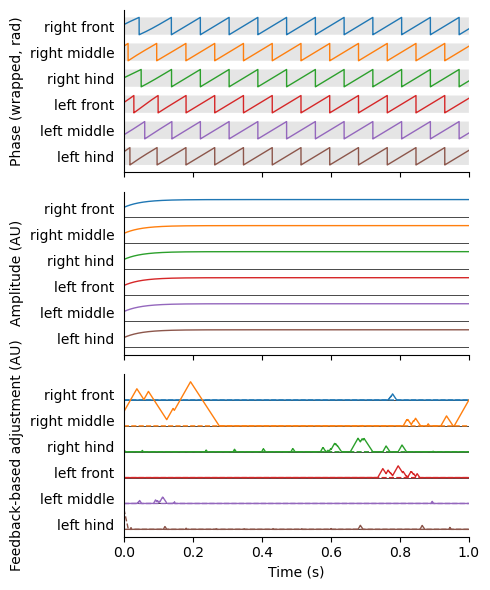

In [7]:
plt.style.use("default")
fig, lines = plot_frame()
Path("outputs").mkdir(exist_ok=True)
fig.savefig("outputs/hybrid.pdf", transparent=True)

In [8]:
plt.style.use("dark_background")
fig, lines = plot_frame(video_layout=True)
with imageio.get_writer("outputs/hybrid.mp4", fps=cam.fps) as writer:
    for t, frame in tqdm(zip(t_frames, cam._frames), total=len(t_frames)):
        writer.append_data(merge_frame_and_time_series(fig, lines, t, frame))
plt.close(fig)

  0%|          | 0/312 [00:00<?, ?it/s]

[swscaler @ 0x6396c40] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 312/312 [00:15<00:00, 20.77it/s]
